This file has only one main purpose. We want to gather the ethnicity as a human-readable word from their ID and save this mapping in a file since the queries take a long time. After gathering the data, we take a quick look on it and evaluate what we got.

In [1]:
import pandas as pd
import os.path
import requests
import time
import pickle

We start by reading the file with character metadata, giving each column its appropriate header.

In [2]:
# import data
colnames = ['Wikipedia movie ID', 'Freebase movie ID', 'Movie release date', 'Character name', 'Actor date of birth', 'Actor gender', 'Actor height (in meters)', 'Actor ethnicity (Freebase ID)', 'Actor name', 'Actor age at movie release', 'Freebase character/actor map ID', 'Freebase character ID', 'Freebase actor ID'] 
chars = pd.read_csv('data/character.metadata.tsv', sep = '\t', names = colnames)

We drop all rows where the Actor ethnicity is `NaN` and show the head of the remaining dataset.

In [3]:
chars_ethNaN = chars.dropna(subset = 'Actor ethnicity (Freebase ID)')
chars_ethNaN.head()

,Wikipedia movie ID,Freebase movie ID,Movie release date,Character name,Actor date of birth,Actor gender,Actor height (in meters),Actor ethnicity (Freebase ID),Actor name,Actor age at movie release,Freebase character/actor map ID,Freebase character ID,Freebase actor ID
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
5,975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
11,975900,/m/03vyhn,2001-08-24,Tres,1959-03-09,M,NaN,/m/064b9n,Rodney A. Grant,42.0,/m/0bgchrs,/m/0bgchrw,/m/03ydsb
27,3196793,/m/08yl5d,2000-02-16,NaN,1937-11-10,M,NaN,/m/0x67,Albert Hall,62.0,/m/0lr37dy,NaN,/m/01lntp


Now we find all unique actor ethnicities since we want to do each query only once.

In [4]:
ethnicity_IDs = chars_ethNaN['Actor ethnicity (Freebase ID)'].unique()

Here, we check first if the mapping file already exists. Otherwise, we start querying and save the relevant results in a dictionary and finally on disk. After each query, we have to take 0.9s break since any shorter break would result in a block from the server.

In [5]:
# create mapping from ethnicity_IDs to ethnicity
query_start = "https://query.wikidata.org/bigdata/namespace/wdq/sparql?format=json&query=PREFIX%20wd%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fentity%2F%3E%0APREFIX%20wdt%3A%20%3Chttp%3A%2F%2Fwww.wikidata.org%2Fprop%2Fdirect%2F%3E%0APREFIX%20wikibase%3A%20%3Chttp%3A%2F%2Fwikiba.se%2Fontology%23%3E%0A%0ASELECT%20%20%3Fs%20%3FsLabel%20%3Fp%20%20%3Fo%20%3FoLabel%20WHERE%20%7B%0A%20%3Fs%20wdt%3AP646%20%22%2Fm%2F"
query_end = "%22%20%0A%0A%20%20%20SERVICE%20wikibase%3Alabel%20%7B%0A%20%20%20%20bd%3AserviceParam%20wikibase%3Alanguage%20%22en%22%20.%0A%20%20%20%7D%0A%20%7D"
fname = 'mapping.pickle'

if os.path.isfile(fname):
    mapping = pickle.load(open(fname,'rb'))
else:
    mapping = {}
    for ID in ethnicity_IDs:
        query = query_start + ID[3:] + query_end
        response = requests.get(query).json()
        try:                                                                 # if the ID gives meaningful result
            ethnicity = response['results']['bindings'][0]['sLabel']['value']
            mapping[ID] = ethnicity
        except:                                                              # if the ID does not give a result
            mapping[ID] = False
        time.sleep(0.9)
    pickle.dump(mapping, open(fname,'wb'))

We now calculate the number of unknown ethnities where the page on Wikidata got deleted and could not be accessed. Note that all unknown ethnicities in the dataset were already removed before.

In [6]:
nEthnicities = len(mapping)
nUnknown = sum(1 for entry in mapping.values() if not entry)
print(f'Number of Ethnicities: {nEthnicities}')
print(f'Thereof unknown      :  {nUnknown}')
print(f'Percentage unknown   :  {nUnknown/nEthnicities*100:.1f} %')

Number of Ethnicities: 479
Thereof unknown      :  49
Percentage unknown   :  10.2 %


As a last step we print the complete list of ethnicities to get a rough overview over what we got. The value `False` refers to ethnicities where the ID did not give any result.

In [7]:
print('List of ethnicites:\n')
list(mapping.values())

List of ethnicites:



[False,
 'African Americans',
 'Omaha people',
 'Jewish people',
 'Irish Americans',
 'Indian Americans',
 'Italians',
 'German Americans',
 'Indians',
 'Ezhava',
 'Malayali',
 'Taiwanese',
 False,
 False,
 'Armenians',
 'Marathi people',
 'Lithuanian American',
 False,
 'Black people',
 'Italian Americans',
 'Danish Americans',
 'American Jews',
 'Scottish American',
 'Puerto Ricans',
 'English people',
 'Irish people',
 'European Americans',
 'Russian Americans',
 'English American',
 'Gujarati people',
 'Spanish American',
 'Bihari people',
 'Nair',
 'Cuban American',
 'white people',
 'Canadian Americans',
 False,
 'Russians',
 'British Nigerian',
 'Yoruba people',
 'Japanese people',
 'Scandinavian Americans',
 'Filipino Americans',
 'Swedish Americans',
 'Finnish Americans',
 'Koreans',
 'French',
 'Welsh people',
 'white Americans',
 'Bengali people',
 'Uruguayans',
 'Iranian people',
 'Mexicans',
 'Dutch American',
 'Hungarian Americans',
 'Spaniards',
 'Gaud Saraswat Brahmin',

I am very happy you scrolled till the end. Here is your reward:

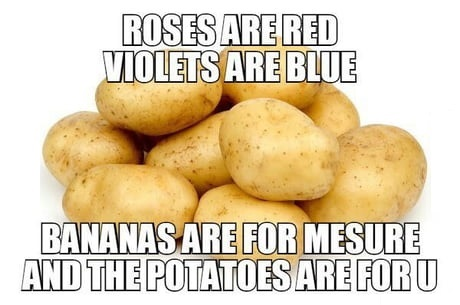